In [150]:
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error as rmse, mean_absolute_error as mae, r2_score as r2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

color_palette = sns.color_palette()

In [163]:
test_MET = pd.read_csv('Data/test2_MET.csv')
test_T640 = pd.read_csv('Data/test2_T640.csv')

test_MET['Timestamp (UTC+0)'] = pd.to_datetime(test_MET['Timestamp (UTC+0)'])
test_T640['Timestamp (UTC+0)'] = pd.to_datetime(test_T640['Timestamp (UTC+0)'])

In [164]:
test = pd.merge(test_T640, test_MET, on='Timestamp (UTC+0)', how='inner')

In [165]:
test.set_index('Timestamp (UTC+0)', inplace=True)
test.sort_index(ascending=True)


,NowCast_PM10_AQI,NowCast_PM2.5_AQI,NowCastConc10,NowCastConc25,PM10,PM25,RH,Temp,WD,WS
Timestamp (UTC+0),,,,,,,,,,
2024-06-01 14:00:00,52,43,30,11.9,22.70591,8.204138,79.44,32.62,190.6,2.918
2024-06-01 15:00:00,46,36,26,10.0,22.91116,7.793385,82.50,31.82,191.2,3.517
2024-06-01 16:00:00,43,32,24,8.9,21.92022,7.975411,90.40,30.73,188.6,3.398
2024-06-01 17:00:00,41,30,23,8.4,27.77257,9.657345,96.40,29.49,204.5,2.616
2024-06-01 18:00:00,45,32,25,9.0,23.32852,9.048307,98.90,28.82,204.2,2.448
...,...,...,...,...,...,...,...,...,...,...
2024-10-04 07:00:00,39,37,22,10.4,50.57724,17.552210,100.70,25.71,279.5,0.579
2024-10-04 08:00:00,59,37,36,14.0,53.23556,16.113410,100.70,26.52,279.2,0.582
2024-10-04 09:00:00,69,53,44,15.0,40.47882,12.505880,95.70,27.85,281.0,0.584


In [7]:
test.index

DatetimeIndex(['2024-10-04 11:00:00', '2024-10-04 10:00:00',
               '2024-10-04 09:00:00', '2024-10-04 08:00:00',
               '2024-10-04 07:00:00', '2024-10-04 06:00:00',
               '2024-10-04 05:00:00', '2024-10-04 04:00:00',
               '2024-10-04 03:00:00', '2024-10-04 02:00:00',
               ...
               '2024-06-01 23:00:00', '2024-06-01 22:00:00',
               '2024-06-01 21:00:00', '2024-06-01 20:00:00',
               '2024-06-01 19:00:00', '2024-06-01 18:00:00',
               '2024-06-01 17:00:00', '2024-06-01 16:00:00',
               '2024-06-01 15:00:00', '2024-06-01 14:00:00'],
              dtype='datetime64[ns]', name='Timestamp (UTC+0)', length=2930, freq=None)

In [166]:
def get_season(date):
    if date.month in [11, 12, 1, 2]:
        return 'Dry Season'
    elif date.month in [3,4]:
        return 'transition season'
    else:
        return 'Wet Season'
    
def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['pm25_lag1'] = df['PM25'].shift(1)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['Season'] = [get_season(date) for date in df.index]

    le = LabelEncoder()
    df['Season'] = le.fit_transform(df['Season'])
    df.dropna(inplace=True)
    
    return df

In [167]:
def prepare_data(df):
    df['Target'] = df['PM25']
    df.dropna(inplace=True)

    df['Hour'] = df.index.hour
    df['Hour'] = df['Hour'].shift(-1)
    df['PM10_lag1'] = df["PM10"].shift(-1)
    df['PM25_lag1'] = df["PM25"].shift(-1)
    df['PM10_AQI_lag1'] = df["NowCast_PM10_AQI"].shift(-1)
    df['PM2.5_AQI_lag1'] = df["NowCast_PM2.5_AQI"].shift(-1)
    df[['RH_lag1', 'Temp_lag1', 'WD_lag1', 'WS_lag1']] = df[['RH', 'Temp', 'WD', 'WS']].shift(-1)
    df['Day'] = df.index.dayofweek

    df.dropna(inplace=True)
    return df



In [172]:
FEATURES = ['Hour', 'Day', 'PM25_lag1', 'RH_lag1', 'Temp_lag1', 'WD_lag1', 'WS_lag1']
TARGET = 'PM25'

test_df = prepare_data(test)
test_df = test_df[FEATURES]
other_df = test_df

In [51]:
test_df

,Hour,Day,PM25_lag1,RH_lag1,Temp_lag1,WD_lag1,WS_lag1
Timestamp (UTC+0),,,,,,,
2024-10-04 11:00:00,10.0,4,9.230798,85.70,29.64,278.1,0.502
2024-10-04 10:00:00,9.0,4,12.505880,95.70,27.85,281.0,0.584
2024-10-04 09:00:00,8.0,4,16.113410,100.70,26.52,279.2,0.582
2024-10-04 08:00:00,7.0,4,17.552210,100.70,25.71,279.5,0.579
2024-10-04 07:00:00,6.0,4,12.004290,100.70,25.45,275.2,0.559
...,...,...,...,...,...,...,...
2024-06-01 19:00:00,18.0,5,9.048307,98.90,28.82,204.2,2.448
2024-06-01 18:00:00,17.0,5,9.657345,96.40,29.49,204.5,2.616
2024-06-01 17:00:00,16.0,5,7.975411,90.40,30.73,188.6,3.398


In [169]:
# model = joblib.load('aq_predict_model.joblib')
model = joblib.load('regression_model.joblib')
test_df['pm25_prediction'] = model.predict(test_df)

C:\Users\Hughe\AppData\Local\Temp\ipykernel_18136\2326605913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pm25_prediction'] = model.predict(test_df)


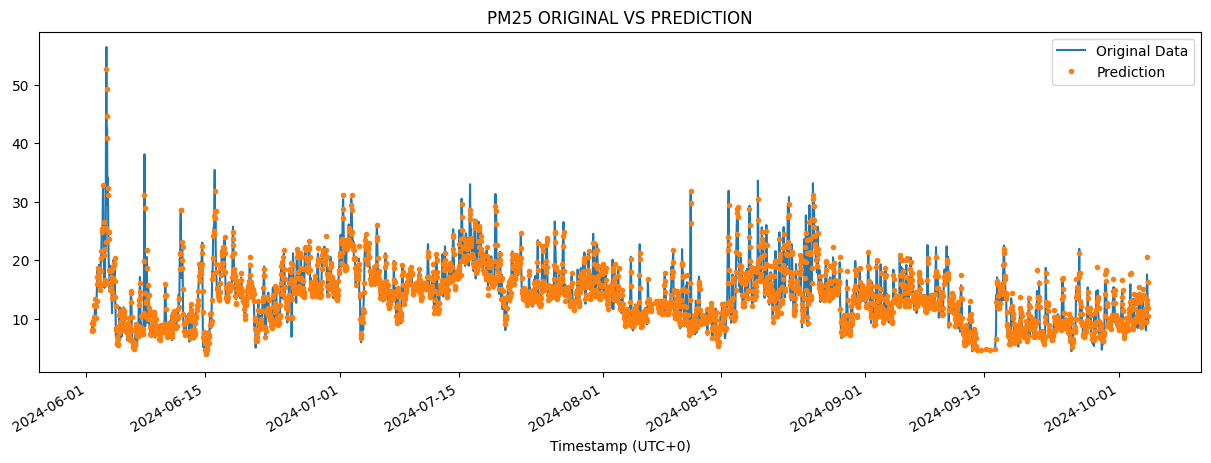

In [170]:
from matplotlib import pyplot as plt


new_df = test.merge(test_df[['pm25_prediction']], how='left', left_index=True, right_index=True)
new_df = new_df[['PM25', 'pm25_prediction']]
ax = new_df[['PM25']].plot(figsize=(15,5))
new_df['pm25_prediction'].plot(ax=ax, style='.')
plt.legend(['Original Data', 'Prediction'])
ax.set_title('PM25 ORIGINAL VS PREDICTION')
plt.show()

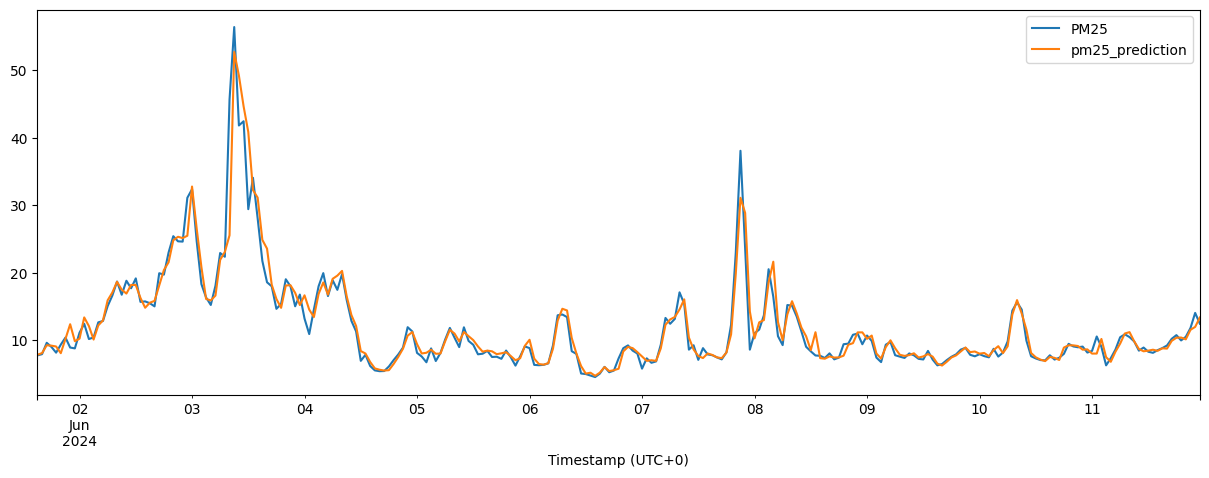

In [54]:
new_df.loc[(test_df.index > '2024-06-01') & (test_df.index < '2024-06-12')]\
    .plot(figsize=(15,5))
plt.show()

In [171]:
score = rmse(new_df['PM25'], new_df['pm25_prediction'])
print(f'RMSE score on test set: {score:0.2f}')


RMSE score on test set: 1.37


In [129]:
r2_score = r2(new_df['PM25'], new_df['pm25_prediction'])
r2_score

0.9282312158292152

In [182]:
def forecast_next_hours(model, last_data, hours=5):
    predictions = []
    current_data = last_data.copy()

    for _ in range(hours):
        # Make prediction
        pred = model.predict(current_data)
        predictions.append(pred[0])  # Store the prediction
        

        # Prepare the next input data
        new_row = {
            'Hour': (current_data['Hour'].values[0] + 1) % 24,  # Increment hour
            'Day': current_data['Day'].values[0],
            'PM25_lag1': pred[0],  # Use the predicted PM2.5 as lagged feature
            'RH_lag1': current_data['RH_lag1'].values[0],
            'Temp_lag1': current_data['Temp_lag1'].values[0],
            'WD_lag1': current_data['WD_lag1'].values[0],
            'WS_lag1': current_data['WS_lag1'].values[0],
        }
        current_data = pd.DataFrame([new_row])  # Update current data for the next prediction

    return predictions

In [131]:
last_data = test_df.iloc[-5:]  # Get the last row of your test data
predictions = forecast_next_hours(model, last_data)
print("Predicted PM2.5 for the next 5 hours:", predictions)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- pm25_prediction


In [159]:
def calculate_aqi(pm25):
    if pm25 < 0:
        return None  # Invalid PM2.5 value
    elif pm25 <= 12.0:
        return (50 / 12.0) * pm25  # Good
    elif pm25 <= 35.4:
        return ((100 - 51) / (35.4 - 12.1)) * (pm25 - 12.1) + 51  # Moderate
    elif pm25 <= 55.4:
        return ((150 - 101) / (55.4 - 35.5)) * (pm25 - 35.5) + 101  # Unhealthy for Sensitive Groups
    elif pm25 <= 150.4:
        return ((200 - 151) / (150.4 - 55.5)) * (pm25 - 55.5) + 151  # Unhealthy
    elif pm25 <= 250.4:
        return ((300 - 201) / (250.4 - 150.5)) * (pm25 - 150.5) + 201  # Very Unhealthy
    elif pm25 <= 500.4:
        return ((500 - 301) / (500.4 - 250.5)) * (pm25 - 250.5) + 301  # Hazardous
    else:
        return 500  # AQI capped at 500

# Example usage
pm25_value = 35.0  # Example PM2.5 concentration
aqi_value = calculate_aqi(pm25_value)
print(f"The AQI for PM2.5 concentration of {pm25_value} µg/m³ is: {aqi_value:.2f}")

The AQI for PM2.5 concentration of 35.0 µg/m³ is: 99.16


## Predicting the next 5 hours

In [196]:
last_data = test_df.iloc[-5:]  # Get the last row of your test data
predictions = forecast_next_hours(model, last_data)

# Generate the datetime for the next 5 hours
last_timestamp = last_data.index[0]  # Get the last timestamp from the last_data
forecast_times = [last_timestamp + pd.Timedelta(hours=i) for i in range(1, 6)]  # Next 5 hours

# Create a DataFrame with predictions and corresponding datetime
forecast_df = pd.DataFrame({
    'Datetime': forecast_times,
    'Predicted_PM25': predictions,
    'Predicted_AQI': [calculate_aqi(pm25) for pm25 in predictions]  # Calculate AQI for each prediction
})

# Set the Datetime as the index
forecast_df.set_index('Datetime', inplace=True)

# Step 3: Combine with actual data for comparison
# Ensure that actual_aqi_df has the same index as forecast_df for proper alignment
comparison_df = test.loc[forecast_df.index, ['NowCast_PM2.5_AQI']].copy()  # Get actual data for the forecast times
comparison_df['Predicted_AQI'] = forecast_df['Predicted_AQI']

# Step 4: Calculate accuracy metrics
# Example: Calculate RMSE
from sklearn.metrics import mean_squared_error

RMSE = rmse(comparison_df['NowCast_PM2.5_AQI'], comparison_df['Predicted_AQI'])
# mae = (comparison_df['NowCast_PM2.5_AQI'] - comparison_df['Predicted_AQI']).abs().mean()
MAE = mae(comparison_df['NowCast_PM2.5_AQI'], comparison_df['Predicted_AQI'])

# Print the comparison DataFrame and accuracy metrics
print(comparison_df)
print(f'RMSE: {RMSE:.2f}')
print(f'MAE: {MAE:.2f}')

                     NowCast_PM2.5_AQI  Predicted_AQI
Datetime                                             
2024-06-01 21:00:00                 32      33.835861
2024-06-01 22:00:00                 35      33.185560
2024-06-01 23:00:00                 33      33.208244
2024-06-02 00:00:00                 33      35.785103
2024-06-02 01:00:00                 35      36.042240
RMSE: 1.76
MAE: 1.54


## Predicting for Next 24 hours

                     NowCast_PM2.5_AQI  Predicted_AQI
Datetime                                             
2024-06-01 21:00:00                 32      33.835861
2024-06-01 22:00:00                 35      33.185560
2024-06-01 23:00:00                 33      33.208244
2024-06-02 00:00:00                 33      35.785103
2024-06-02 01:00:00                 35      36.042240
RMSE: 1.76
MAE: 1.54


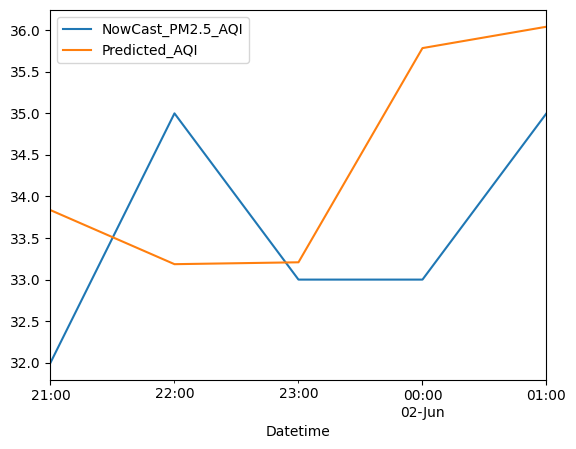

In [198]:
last_data = test_df.iloc[-5:]  # Get the last row of your test data
predictions = forecast_next_hours(model, last_data)

# Generate the datetime for the next 5 hours
last_timestamp = last_data.index[0]  # Get the last timestamp from the last_data
forecast_times = [last_timestamp + pd.Timedelta(hours=i) for i in range(1, 6)]  # Next 5 hours

# Create a DataFrame with predictions and corresponding datetime
forecast_df = pd.DataFrame({
    'Datetime': forecast_times,
    'Predicted_PM25': predictions,
    'Predicted_AQI': [calculate_aqi(pm25) for pm25 in predictions]  # Calculate AQI for each prediction
})

# Set the Datetime as the index
forecast_df.set_index('Datetime', inplace=True)

# Step 3: Combine with actual data for comparison
# Ensure that actual_aqi_df has the same index as forecast_df for proper alignment
comparison_df = test.loc[forecast_df.index, ['NowCast_PM2.5_AQI']].copy()  # Get actual data for the forecast times
comparison_df['Predicted_AQI'] = forecast_df['Predicted_AQI']

# Step 4: Calculate accuracy metrics
# Example: Calculate RMSE
from sklearn.metrics import mean_squared_error

RMSE = rmse(comparison_df['NowCast_PM2.5_AQI'], comparison_df['Predicted_AQI'])
# mae = (comparison_df['NowCast_PM2.5_AQI'] - comparison_df['Predicted_AQI']).abs().mean()
MAE = mae(comparison_df['NowCast_PM2.5_AQI'], comparison_df['Predicted_AQI'])

# Print the comparison DataFrame and accuracy metrics
comparison_df.plot()
print(comparison_df)
print(f'RMSE: {RMSE:.2f}')
print(f'MAE: {MAE:.2f}')